In [1]:
# %load_ext nb_black

In [2]:
import os

import numpy as np
import pandas as pd

import pyro

In [3]:
from muvi.models import MuVI
from muvi.callbacks import EarlyStoppingCallback, LogCallback

from muvi.data import DataGenerator

from muvi.plotting import lined_heatmap
from muvi.utils import get_free_gpu_idx

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f68374d3180>


In [5]:
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

In [6]:
try:
    gpu_idx = get_free_gpu_idx()
    print("Using GPU #%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU #1


First, lets generate some multi-view synthetic data. The dataset comprises 200 samples and four views, each having 400 features. In addition, the underlying relationships across views consist of 2 factors shared among all views, 14 factors shared among a subset of two or three views, as well as a private factor for each view. Finally, we may introduce additional covariates that can be modelled jointly during training.

In [7]:
seed = 123
n_samples = 200
n_features = [400, 400, 400, 400]
n_views = len(n_features)
likelihoods = ["normal" for _ in range(n_views)]

n_fully_shared_factors = 2
n_partially_shared_factors = 14
n_private_factors = n_views
n_factors = n_fully_shared_factors + n_partially_shared_factors + n_private_factors

n_covariates = 2


In [8]:
dg = DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_fully_shared_factors=n_fully_shared_factors,
    n_partially_shared_factors=n_partially_shared_factors,
    n_private_factors=n_private_factors,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed)

# standardise data
dg.normalise(with_std=False)


2022-03-09 17:59:05,748 - muvi.data - WARNING - Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.


In [9]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<AxesSubplot:>

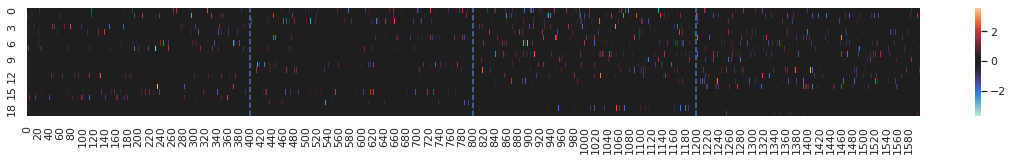

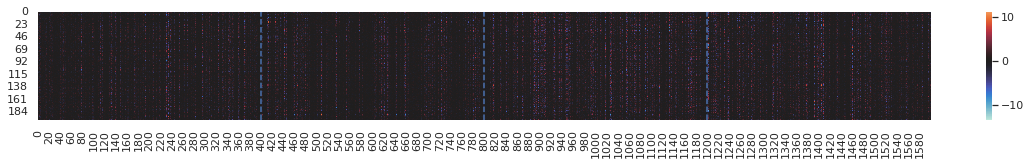

In [10]:
# factor loadings should be fairly sparse
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(dg.y, vlines=vlines, center=0)

Now we can perturb the true underlying mask of the factor loadings in order to inform the model noisy feature sets. We do so by introducing false positives and false negatives controlled by a `noise_fraction` parameter. We may also determine which views we would like to inform via `informed_views`, a list of view indices. Here we only inform the first view (index 0).

2022-03-09 17:59:13,623 - muvi.data - WARNING - Factor 2 is completely off, inserting 9.65% false positives.
2022-03-09 17:59:13,625 - muvi.data - WARNING - Factor 5 is completely off, inserting 9.65% false positives.
2022-03-09 17:59:13,626 - muvi.data - WARNING - Factor 8 is completely off, inserting 9.65% false positives.
2022-03-09 17:59:13,628 - muvi.data - WARNING - Factor 9 is completely off, inserting 9.65% false positives.
2022-03-09 17:59:13,629 - muvi.data - WARNING - Factor 10 is completely off, inserting 9.65% false positives.
2022-03-09 17:59:13,630 - muvi.data - WARNING - Factor 11 is completely off, inserting 9.65% false positives.
2022-03-09 17:59:13,631 - muvi.data - WARNING - Factor 13 is completely off, inserting 9.65% false positives.
2022-03-09 17:59:13,632 - muvi.data - WARNING - Factor 17 is completely off, inserting 9.65% false positives.
2022-03-09 17:59:13,633 - muvi.data - WARNING - Factor 18 is completely off, inserting 9.65% false positives.
2022-03-09 17:

<AxesSubplot:>

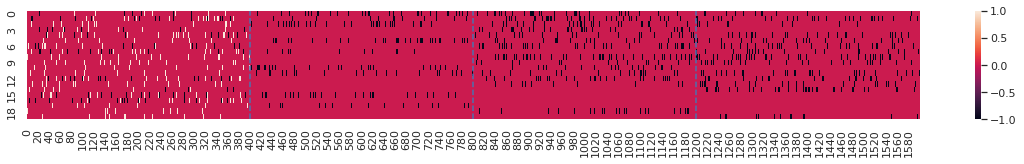

In [11]:
# perturb 
noise_fraction = 0.5
# inform only first view with noisy prior
informed_views = [0]

_ = dg.get_noisy_mask(
    rng,
    noise_fraction=noise_fraction,
    informed_view_indices=informed_views,
)

# false positives and false negatives
lined_heatmap(dg.noisy_w_mask - dg.w_mask, vlines=vlines)

Now that we generated a noisy version of the true factor loadings mask, we need to inform our model by relaxing the binary prior information to values larger than zero for the slab widths of the regularized horseshoe. We do so by providing a `confidence` that ranges from 0 to 1 when adding the prior mask. The `confidence` encodes our prior belief regarding the (noisy) prior information. A weak belief corresponds to values around 0.95, medium to 0.99 and strong to larger than 0.99 (closer to 1.0). As a rule of thumb, a `confidence` of 0.99 provides the best results on average.

In [12]:
# create an instance of the model
model = MuVI(
    n_factors=n_factors,
    observations=dg.ys,
    covariates=dg.x,
    likelihoods=likelihoods,
    use_gpu=True,
)

# add (noisy) prior information
model.add_prior_mask(dg.noisy_w_masks, confidence=0.99)

Now we can train our model via a (stochastic) variational inference algorithm. We may also provide additional callbacks during training such as `EarlyStoppingCallback` for terminating the optimization procedure when the ELBO improvements are insignificant, or `LogCallback` for keeping track of relevant metric scores and how they progress during training.

In [13]:
# set number of iterations
n_iterations = 10000

# this callback logs metrics of the training every X steps to better gauge the training progress
log_callback = LogCallback(
    model,
    n_iterations,
    n_checkpoints=10,
    y_true=dg.ys,
    mask=[mask.astype(bool) for mask in dg.w_masks],
    binary_scores_at=500,
    threshold=0.1,
    log=True,
    log_frequency=10,
    n_annotated=n_factors,
    informed_views=informed_views,
)


In [14]:
# set random seed
pyro.set_rng_seed(seed)

# clean start
print("Cleaning parameter store")
pyro.enable_validation(True)
pyro.clear_param_store()

loss_history, _ = model.fit(
    batch_size=n_samples,
    n_iterations=n_iterations,
    n_particles=20,
    learning_rate=0.01,
    optimizer='clipped',
    verbose=1,
    callbacks=[
        log_callback,
        EarlyStoppingCallback(
            n_iterations,
            min_iterations=1000,
            window_size=10,
            tolerance=1e-5,
            patience=10,
        )
    ],
)



Cleaning parameter store
2022-03-09 17:59:17,482 - muvi.models - INFO - Using complete dataset
2022-03-09 17:59:17,484 - muvi.models - INFO - Preparing model and guide...
2022-03-09 17:59:27,065 - muvi.models - INFO - Preparing optimizer...
2022-03-09 17:59:27,069 - muvi.models - INFO - Preparing SVI...
2022-03-09 17:59:27,070 - muvi.models - INFO - Preparing training data...
2022-03-09 17:59:27,158 - muvi.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2022-03-09 17:59:27,357 - root - INFO - Guessed max_plate_nesting = 3


 10%|█         | 1003/10000 [00:47<07:42, 19.45it/s, ELBO=1.42e+3]

Average fraction of inactive loadings for each view:  0.952 0.986 0.970 0.972
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
view #: (acc, prec, rec, f1)
view 0: (0.991, 0.906, 0.902, 0.904)
Overall rmse for each view:  0.349 0.635 0.746 0.683


 20%|██        | 2003/10000 [01:25<05:31, 24.11it/s, ELBO=982]    

Average fraction of inactive loadings for each view:  0.952 0.963 0.944 0.950
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
view #: (acc, prec, rec, f1)
view 0: (0.996, 0.963, 0.951, 0.957)
Overall rmse for each view:  0.320 0.351 0.444 0.441


 30%|███       | 3002/10000 [02:07<05:48, 20.06it/s, ELBO=895]

Average fraction of inactive loadings for each view:  0.953 0.962 0.939 0.943
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
view #: (acc, prec, rec, f1)
view 0: (0.998, 0.989, 0.969, 0.979)
Overall rmse for each view:  0.321 0.350 0.384 0.364


 40%|████      | 4001/10000 [02:53<04:55, 20.31it/s, ELBO=880]

Average fraction of inactive loadings for each view:  0.953 0.962 0.938 0.941
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
view #: (acc, prec, rec, f1)
view 0: (0.998, 0.992, 0.969, 0.980)
Overall rmse for each view:  0.321 0.350 0.385 0.343


 50%|█████     | 5003/10000 [03:38<04:08, 20.09it/s, ELBO=866]

Average fraction of inactive loadings for each view:  0.953 0.959 0.938 0.941
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
view #: (acc, prec, rec, f1)
view 0: (0.998, 0.995, 0.966, 0.980)
Overall rmse for each view:  0.322 0.322 0.383 0.343


 60%|██████    | 6002/10000 [04:25<03:18, 20.11it/s, ELBO=863]

Average fraction of inactive loadings for each view:  0.953 0.958 0.937 0.941
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
view #: (acc, prec, rec, f1)
view 0: (0.998, 0.995, 0.966, 0.980)
Overall rmse for each view:  0.322 0.317 0.382 0.343


 70%|███████   | 7001/10000 [05:11<02:28, 20.22it/s, ELBO=833]

Average fraction of inactive loadings for each view:  0.953 0.958 0.932 0.941
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
view #: (acc, prec, rec, f1)
view 0: (0.999, 0.997, 0.972, 0.984)
Overall rmse for each view:  0.322 0.316 0.318 0.342


 80%|████████  | 8003/10000 [05:57<01:36, 20.61it/s, ELBO=832]

Average fraction of inactive loadings for each view:  0.953 0.958 0.932 0.941
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
view #: (acc, prec, rec, f1)
view 0: (0.998, 0.997, 0.969, 0.983)
Overall rmse for each view:  0.322 0.316 0.317 0.343


 83%|████████▎ | 8280/10000 [06:09<01:16, 22.41it/s, ELBO=831]

Relative improvement of 4.372e-06 < 1e-05 for 10 step(s) in a row, stopping early.


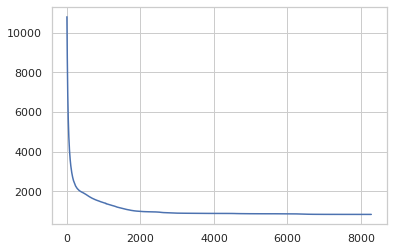

In [15]:
# plot the ELBO across iterations
plt.plot(loss_history)

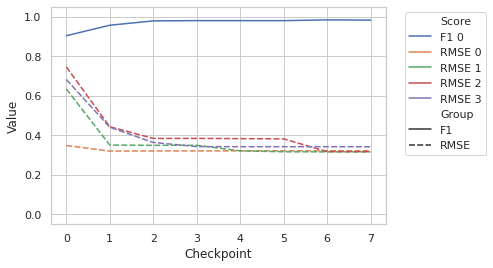

In [16]:
df = pd.DataFrame(log_callback.scores)
df["checkpoint"] = df.index
df = pd.melt(df, id_vars=["checkpoint"], value_vars=df.columns[:-1])
df.columns = ["Checkpoint", "Score", "Value"]
df["Score"] = df["Score"].map(lambda s: ' '.join([p.upper() for p in s.split('_')]))
df["Group"] = df["Score"].str.split(' ').str[0]


g = sns.lineplot(
    data=df[df["Score"].str.contains("RMSE|F1")],
    x="Checkpoint",
    y="Value",
    hue="Score",
    style="Group",
)
g.set(ylim=(-0.05, 1.05))
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

Once the training converges, we may inspect the learned parameters and compare them to the true parameters.

<AxesSubplot:>

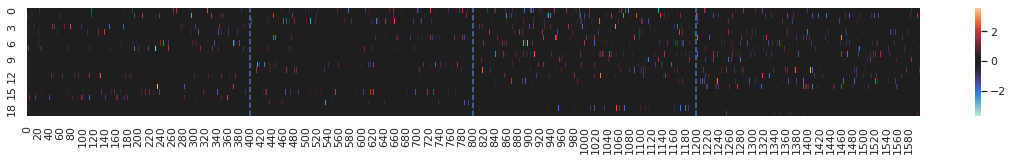

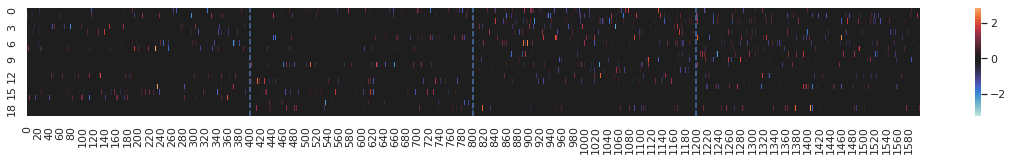

In [17]:
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(model.get_w(), vlines=vlines, center=0)

In [18]:
from muvi.utils import compute_confusion_matrix
from muvi.plotting import plot_confusion_matrix

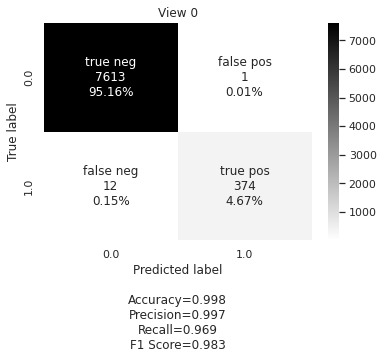

In [19]:
threshold = 0.1
# plot the confusion matrix between the true loadings activity and the learned loadings activity for the informed views
for m in informed_views:
    cf_matrix = compute_confusion_matrix(dg.w_masks[m].flatten(), (np.abs(model.get_w(as_list=True)[m]).flatten() > threshold))
    metrics = plot_confusion_matrix(
        cf_matrix,
        group_names=["true neg", "false pos", "false neg", "true pos"],
        categories=["0.0", "1.0"],
        cmap="binary",
        title=f"View {m}"
    )
    plt.show()

Due to non-identifiability of FA models, it is sometimes necessary to permute the order of the factors match the true order. We do so by first computing the cosine similarities between the true factor loadings mask and the learned factor loading activations (based on a threshold). Then, we find the optimal permutation by matching each factor with its corresponding true factor index based on the largest cosine similarity.

In [20]:
from muvi.utils import compute_cosine_similarity, optim_perm

<AxesSubplot:>

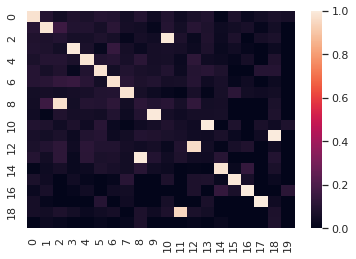

In [21]:
cos_sim = compute_cosine_similarity(dg.w_mask, np.abs(model.get_w()) > threshold)
sns.heatmap(cos_sim, annot=False)

/home/aqoku/projects/muvi/muvi/utils.py:75: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = linprog(


<AxesSubplot:>

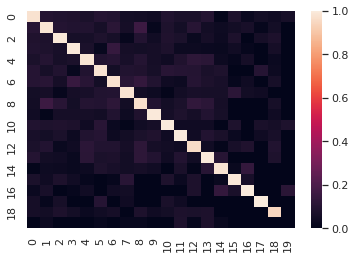

In [22]:
opt_order = optim_perm(cos_sim).argmax(axis=0)
sns.heatmap(cos_sim[:, opt_order], annot=False)

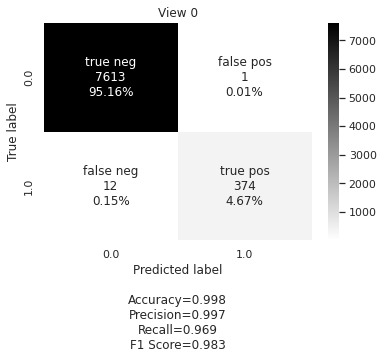

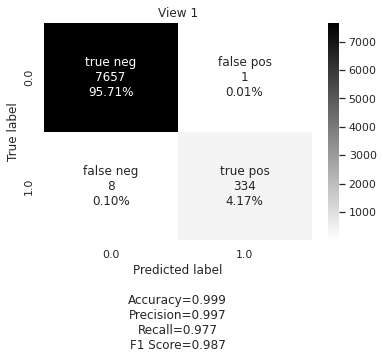

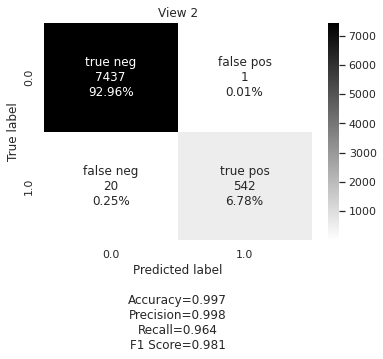

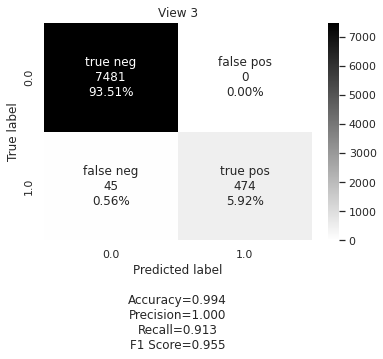

In [23]:
# now we can recompute the confusion matrix for each view after factor permutation
for m in range(model.n_views):
    cf_matrix = compute_confusion_matrix(dg.w_masks[m].flatten(), (np.abs(model.get_w(as_list=True)[m][opt_order, :]).flatten() > threshold))
    metrics = plot_confusion_matrix(
        cf_matrix,
        group_names=["true neg", "false pos", "false neg", "true pos"],
        categories=["0.0", "1.0"],
        cmap="binary",
        title=f"View {m}"
    )
    plt.show()

Our model also infers the relationship across subsets of views by learning a set of `factor_scales` for each view. The lower the value of a factor scale $k$ in view $m$, the less significant this factor is for view $m$.

In [24]:
factor_scales = model.get_factor_scale()[:, opt_order]
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]

<AxesSubplot:>

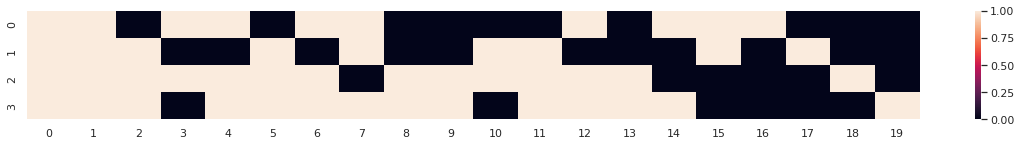

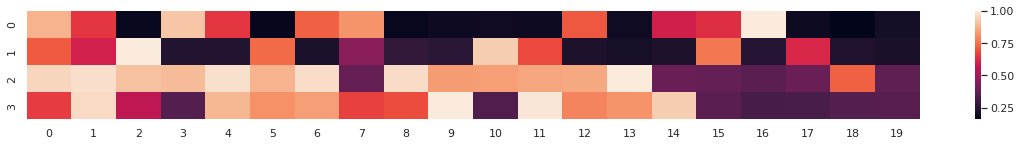

In [25]:
lined_heatmap(dg.view_factor_mask)
lined_heatmap(factor_scales)

We can also go one level deeper and inspect a single factors by extractin its factor loadings and plotting the sorted weights along with their corresponding state, one of true positive (TP), true negative (TN), false positive (FP) and false negative (FN). Ideally we would like to see true active loadings away from zero, i.e. true positives (TP), false negatives (FN), and true inactive loadings close to zero, i.e. false positives (FP), true negatives (TN)

In [26]:

def plot_factor_activity(
        true_w, 
        approx_w, 
        true_mask, 
        noisy_mask, 
        factor_idx=0,
        ylim=None,
        **kwargs,
    ):
    
    true_w_col = true_w[factor_idx, :]
    w_col = approx_w[factor_idx, :]
    true_mask_col = true_mask[factor_idx, :]
    noisy_mask_col = noisy_mask[factor_idx, :]

    activity_df = pd.DataFrame(
        {
            "true_weight": true_w_col,
            "weight": w_col,
            "true_mask": true_mask_col,
            "noisy_mask": noisy_mask_col,
            "TP": true_mask_col * noisy_mask_col,
            "FP": (1 - true_mask_col) * noisy_mask_col,
            "TN": (1 - true_mask_col) * (1 - noisy_mask_col),
            "FN": true_mask_col * (1 - noisy_mask_col),
        }
    )
    activity_df.sort_values(["true_weight"], inplace=True)

    score_cols = ["TP", "FP", "TN", "FN"]

    assert (activity_df.loc[:, score_cols].values.sum(1) == 1).all()
    activity_df["state"] = (
        activity_df.loc[:, score_cols]
        .astype(np.int32)
        .dot(activity_df.loc[:, score_cols].columns + "+")
        .str[:-1]
    )
    activity_df["true state"] = [
        "on" if f > 0.5 else "off" for f in activity_df["true_mask"]
    ]
    activity_df["idx"] = list(range(len(w_col)))

    g = sns.scatterplot(
        data=activity_df,
        x="idx",
        y="weight",
        hue="state",
        hue_order=["TP", "FN", "TN", "FP"],
        style="true state",
        style_order=["on", "off"],
        size="state",
        sizes={"TP": 32, "FN": 32, "TN": 16, "FP": 16},
        linewidth=0.01,
        **kwargs,
    )
    g.set_xlabel("")
    joint_handles, joint_labels = g.get_legend_handles_labels()
    g.legend(
        # loc="lower right",
        handles=[h for i, h in enumerate(joint_handles) if i not in [0, 5]],
        labels=[h for i, h in enumerate(joint_labels) if i not in [0, 5]],
    )
    if ylim is not None:
        g.set(ylim=ylim)

    return g, activity_df


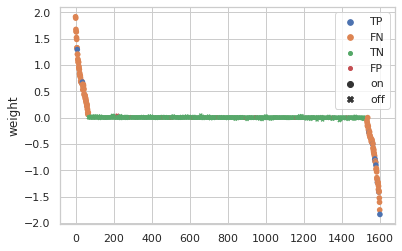

In [27]:
g, _ = plot_factor_activity(dg.w, model.get_w()[opt_order, :], dg.w_mask, dg.noisy_w_mask, factor_idx=0)